# Import Libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd



repo_path = os.path.dirname(os.path.abspath(""))
CHECKOUT_PATH = repo_path
DATASET_PATH = os.path.join(repo_path, "datasets")

os.chdir(CHECKOUT_PATH)
sys.path.insert(0, CHECKOUT_PATH)

In [11]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import pandas as pd
#import astartes as at
#from astartes import train_test_split, train_val_test_split

from alinemol.utils import eval_roc_auc, eval_pr_auc, eval_acc, rescale, compute_linear_fit
from alinemol.utils import plot_ID_OOD, plot_ID_OOD_sns #visualize_chemspace
from alinemol.utils import split_molecules_train_test, split_molecules_train_val_test

#from alinemol.splitters import ScaffoldSplit, RandomSplit, SphereExclusionSplit, KMeansSplit, DBScanSplit, OptiSimSplit

light_color = plt.get_cmap("plasma").colors[170]
#dark_color = plt.get_cmap("plasma").colors[5]
dark_color = "black"


#matplotlib.use("pgf")

matplotlib.rcParams.update(
    {
        "pgf.texsystem": "pdflatex",
        "font.family": "serif",
        "font.serif": "Computer Modern Roman",
        "font.size": 20,
        "text.usetex": True,
        "pgf.rcfonts": False,
    }
)

# Visualize the splits in 2D

In [45]:
# Function for visulizing the chemical space (available in utils/plot_utils.py)
import umap
import datamol as dm
from typing import List

def visualize_chemspace(
    data: pd.DataFrame, split_names: List[str], mol_col: str = "smiles", size_col=None, size=10, normalize=False
) -> None:
    """
    Visualize chemical space using UMAP

    Args:
        data (pd.DataFrame): pd.DataFrame with columns "smiles", "label", "split"
        split_names (list): list of split names
        mol_col (str): name of column containing SMILES
        size_col: name of column containing size information

    Returns:
        None
    """
    features = [dm.to_fp(mol) for mol in data[mol_col]]
    if normalize:
        features = StandardScaler().fit_transform(features)
    embedding = umap.UMAP().fit_transform(features)
    print(embedding.shape)
    data["UMAP_0"], data["UMAP_1"] = embedding[:, 0], embedding[:, 1]
    for split_name in split_names:
        plt.figure(figsize=(10, 6))
        fig = sns.scatterplot(
            data=data, x="UMAP_0", y="UMAP_1", s=size, style=size_col, hue=split_name, alpha=0.5, hue_order=["Train", "Test"]
        )
        fig.set_title(f"UMAP Embedding of compounds for {split_name} split")
        fig.legend(loc="upper right")
        plt.show()

In [131]:
index = 3
dataset_categoty = "TDC"
dataset_name = "CYP3A4"
split_types = ["scaffold", "molecular_weight", "kmeans", "max_dissimilarity", "perimeter"]

dfs = []
for i, split_type in enumerate(split_types):
    # Load the dataset
    train_df = pd.read_csv(os.path.join(DATASET_PATH, dataset_categoty, dataset_name, "split", split_type, f"train_{index}.csv"))
    print(train_df.shape)
    test_df  = pd.read_csv(os.path.join(DATASET_PATH, dataset_categoty, dataset_name, "split", split_type, f"test_{index}.csv"))
    print(test_df.shape)
    train_test_list = ["Train"]*len(train_df) + ["Test"]*len(test_df)
    df = pd.concat([train_df, test_df])
    df[split_type] = train_test_list
    print(df.shape)
    dfs.append(df)
    if i != 0:
        df = pd.merge(dfs[0], df, on=["smiles", "label"], how="outer")
        dfs[0] = df


(9963, 2)
(2315, 2)
(12278, 3)
(9822, 2)
(2456, 2)
(12278, 3)
(11192, 2)
(1086, 2)
(12278, 3)
(10345, 2)
(1933, 2)
(12278, 3)
(9678, 2)
(2600, 2)
(12278, 3)


In [132]:
df

,smiles,label,scaffold,molecular_weight,kmeans,max_dissimilarity,perimeter
0,CCCC(=O)Nc1ccc(N2CCN(CC)CC2)c(Cl)c1,0,Train,Train,Train,Train,Train
1,O=c1[nH]c2cc3c(cc2cc1CN(CCCO)Cc1nnnn1Cc1ccc(F)...,1,Train,Test,Train,Train,Train
2,CC(=O)N(c1ccc2oc(=O)sc2c1)S(=O)(=O)c1cccs1,1,Train,Train,Train,Train,Train
3,COc1ccccc1C(c1nnnn1C(C)(C)C)N1CCN(Cc2ccncc2)CC1,1,Train,Train,Train,Train,Train
4,CC(=O)Nc1cccc(NC(=O)C2CCCN2C(=O)Nc2ccccc2C)c1,0,Train,Train,Train,Train,Train
...,...,...,...,...,...,...,...
12273,O=C1C2=CCc3c(c(O)n(-c4ccc(F)cc4F)c3O)[C@H]2[C@...,1,Test,Train,Train,Train,Train
12274,O=C1C2=CCc3c(c(O)n(Cc4ccc5c(c4)OCO5)c3O)[C@@H]...,0,Test,Train,Train,Train,Train
12275,O=C1C[C@@H](O)[C@@H](O)[C@@H]2c3c(c(O)n(-c4ccc...,0,Test,Train,Train,Test,Train
12276,O=C1C=C[C@@H](O)[C@H]2c3c(c(O)n(C[C@@H]4CCCO4)...,0,Test,Train,Train,Test,Train


In [133]:
(df['scaffold'] == "Test").sum() / len(df), (df['scaffold'] == "Train").sum() / len(df)

(0.1885486235543248, 0.8114513764456752)

In [134]:
#import umap.plot
#umap.plot.points(features, labels=label)

(12278, 2)


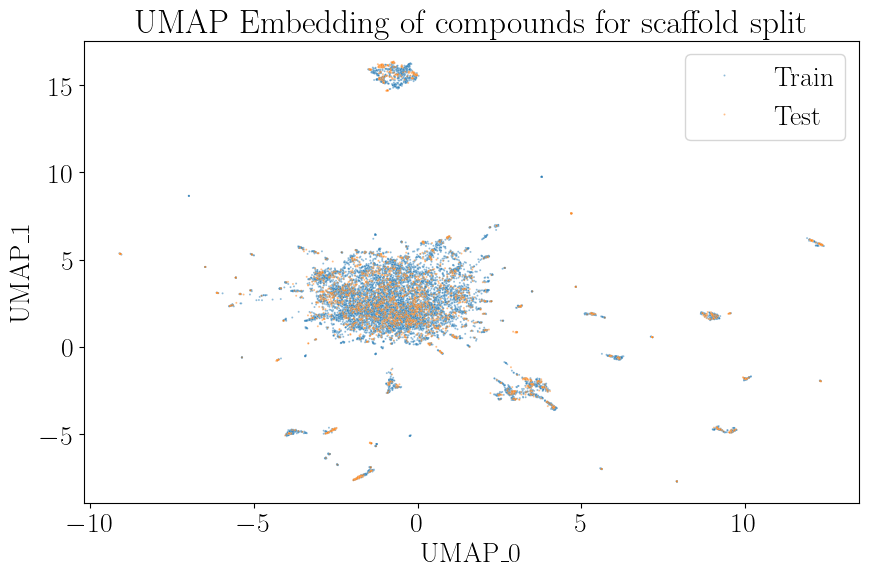

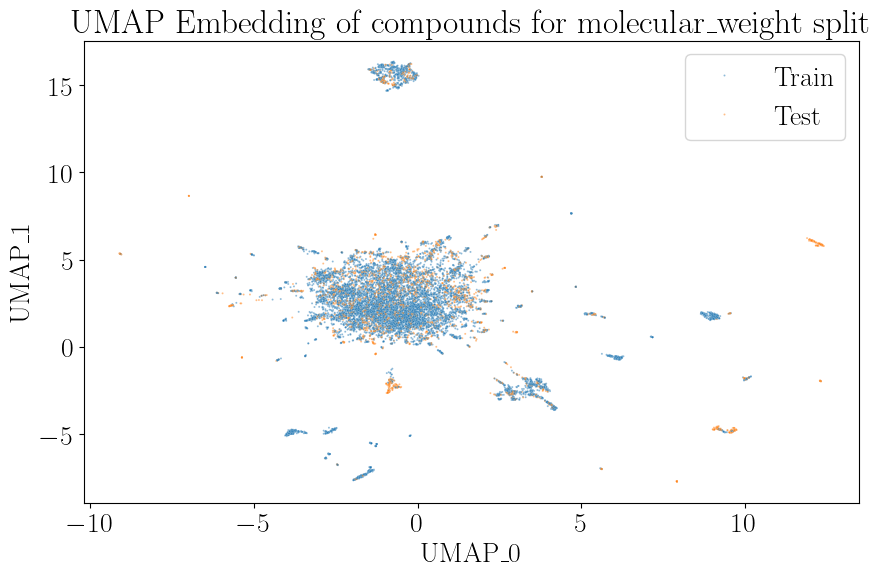

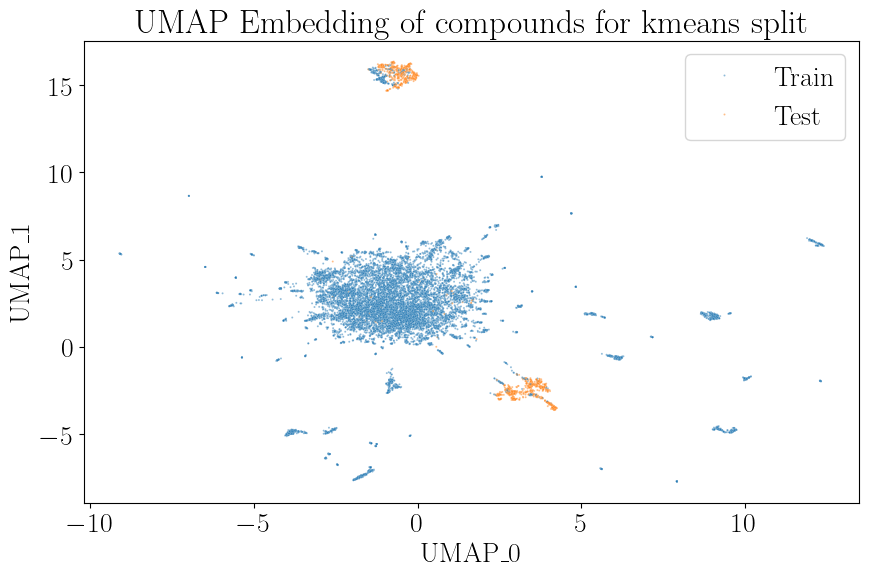

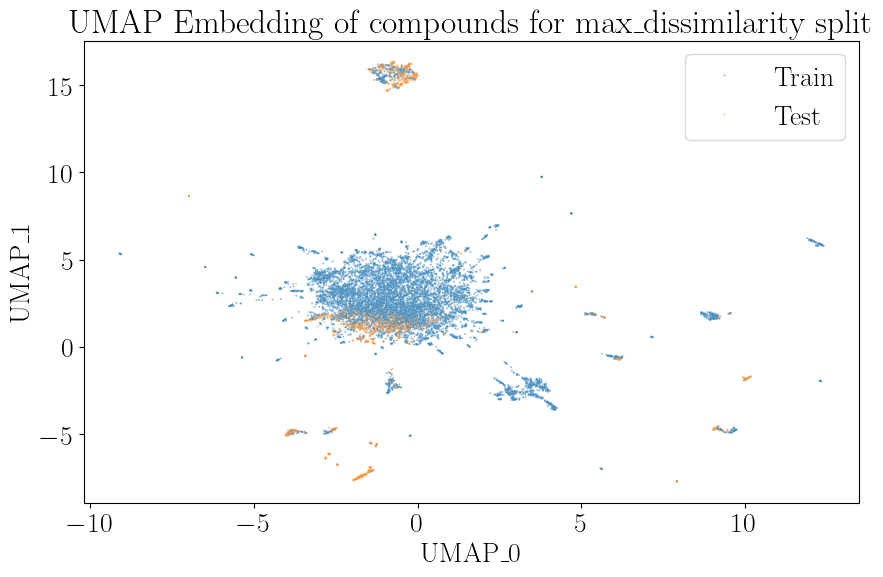

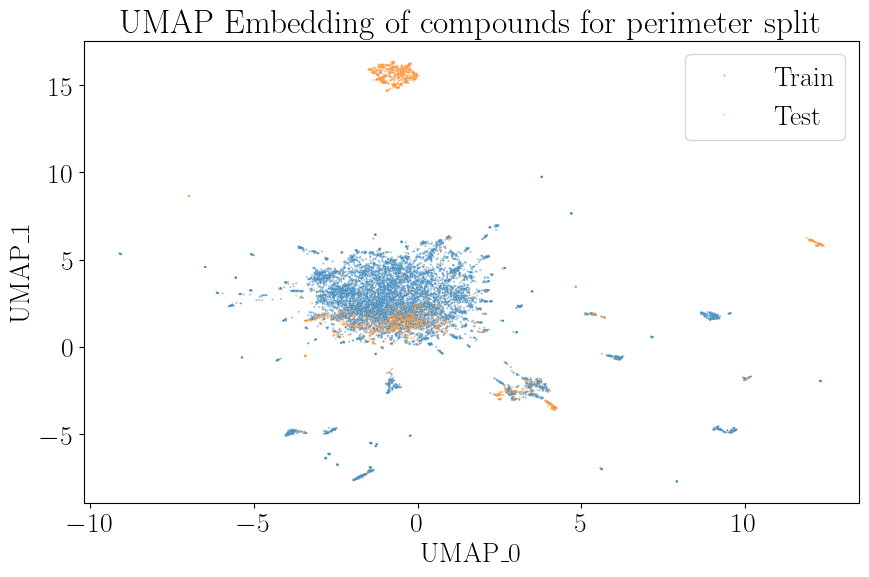

In [135]:
visualize_chemspace(df, split_names=split_types, size=2, normalize=False)

In [4]:
dataset_categoty = "TDC"
dataset_name = "CYP2C19"
split_type = "scaffold"
SPLIT_PATH = os.path.join(DATASET_PATH, dataset_categoty, dataset_name, "split", split_type)

train_path = os.path.join(SPLIT_PATH, "train_0.csv")
test_path = os.path.join(SPLIT_PATH, "test_0.csv")

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [8]:
train_test_list = ["train"]*len(train_df) + ["test"]*len(test_df)
split_df = pd.concat([train_df, test_df])
split_df[split_type] = train_test_list

In [11]:
split_df[split_type].value_counts()

scaffold
train    10026
test      2587
Name: count, dtype: int64

In [12]:
split_df

,smiles,label,scaffold
0,CC(=O)N(c1ccc2oc(=O)sc2c1)S(=O)(=O)c1cccs1,1,train
1,Clc1ccccc1-c1n[nH]c(-c2ccccc2)n1,1,train
2,COc1ccccc1C(c1nnnn1C(C)(C)C)N1CCN(Cc2ccncc2)CC1,1,train
3,COc1ccccc1CNC(=O)Cn1nnc(-c2ccncc2)n1,1,train
4,CC(=O)Nc1cccc(NC(=O)C2CCCN2C(=O)Nc2ccccc2C)c1,0,train
...,...,...,...
2582,O=C1C2=CCc3c(c(O)n(-c4ccc(F)cc4F)c3O)[C@H]2[C@...,0,test
2583,O=C1C2=CCc3c(c(O)n(C4CCCCC4)c3O)[C@@H]2[C@H](O...,0,test
2584,O=C1[C@H]2O[C@@H]2[C@@H](O)[C@H]2[C@H]1CCn1c(=...,0,test
2585,Oc1c2c(c(O)n1Cc1ccccc1)[C@H]1C(=CC2)C2(OCCCO2)...,0,test


<Figure size 640x480 with 0 Axes>

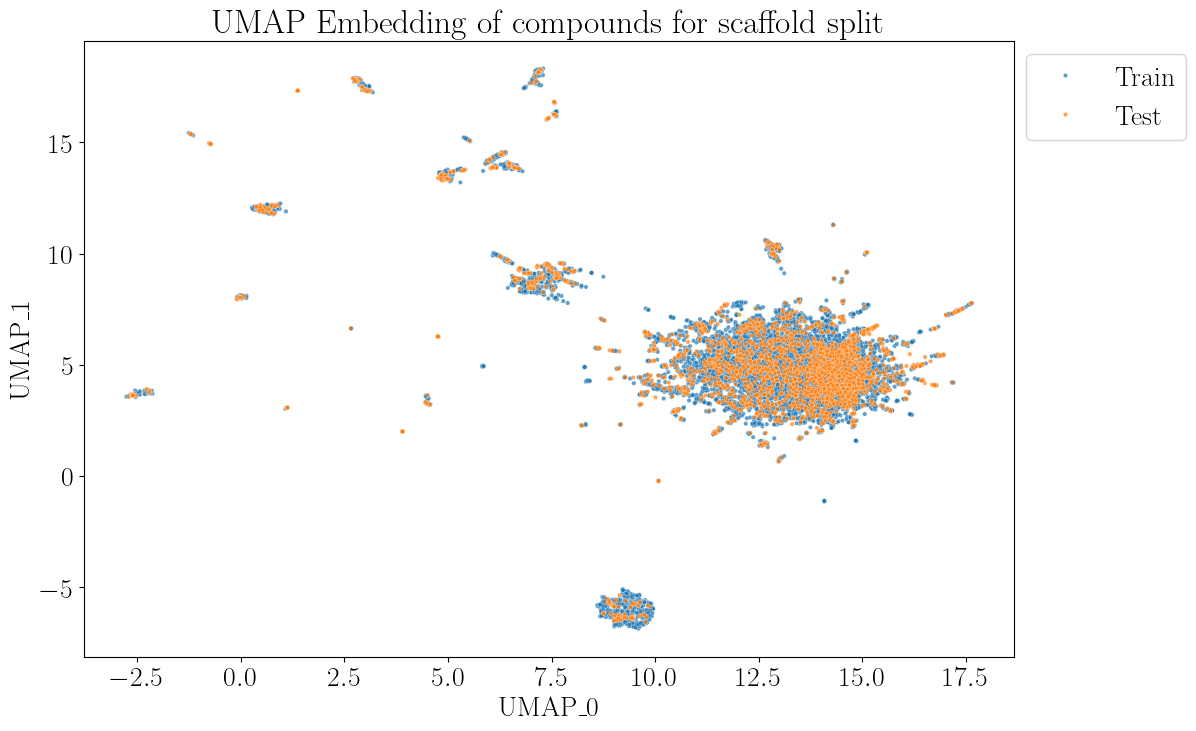

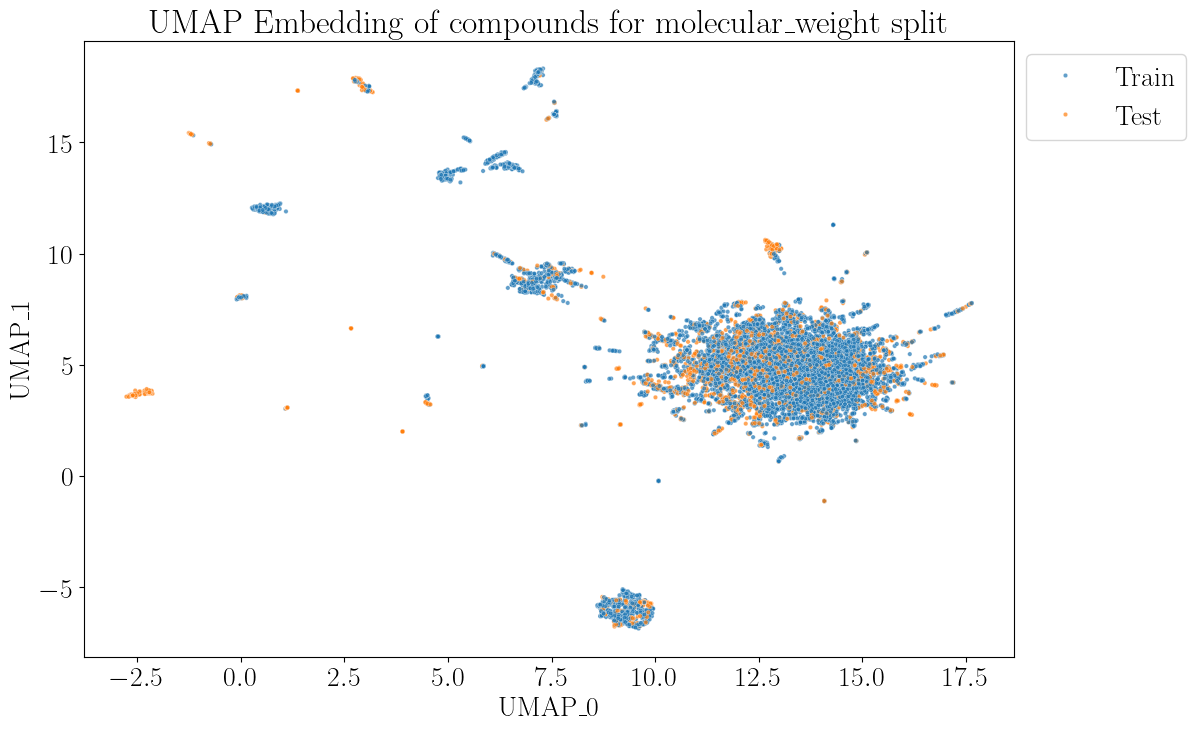

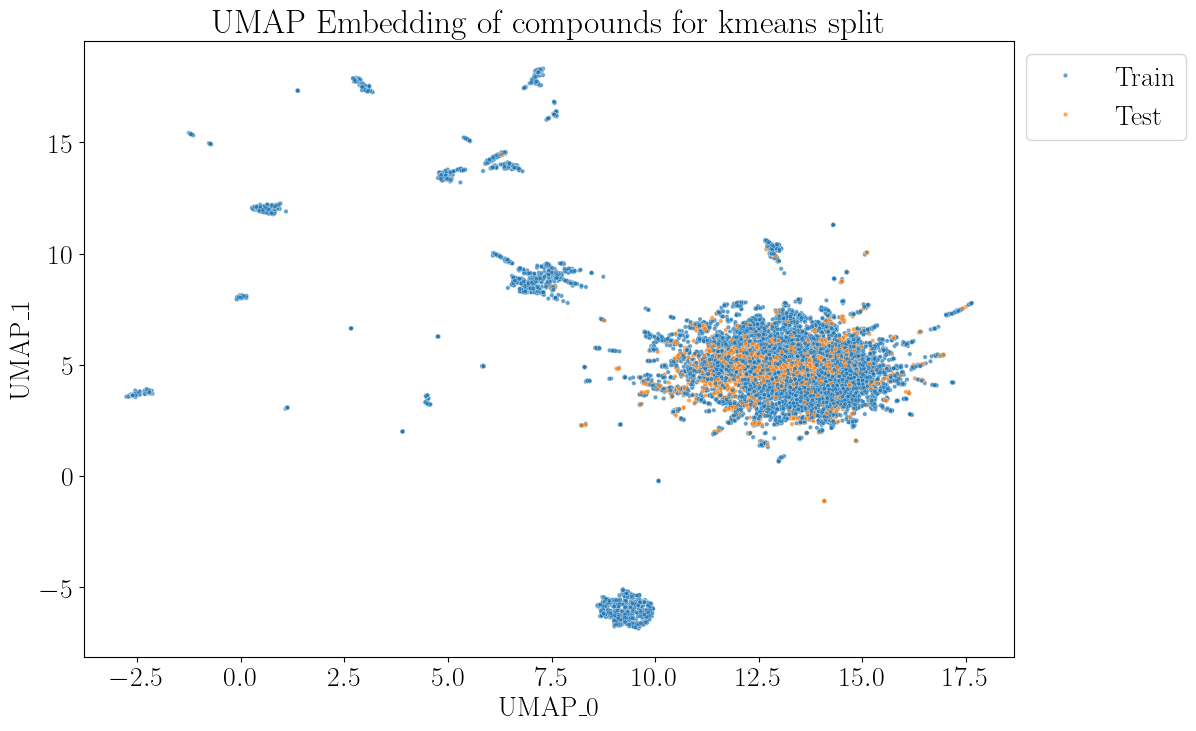

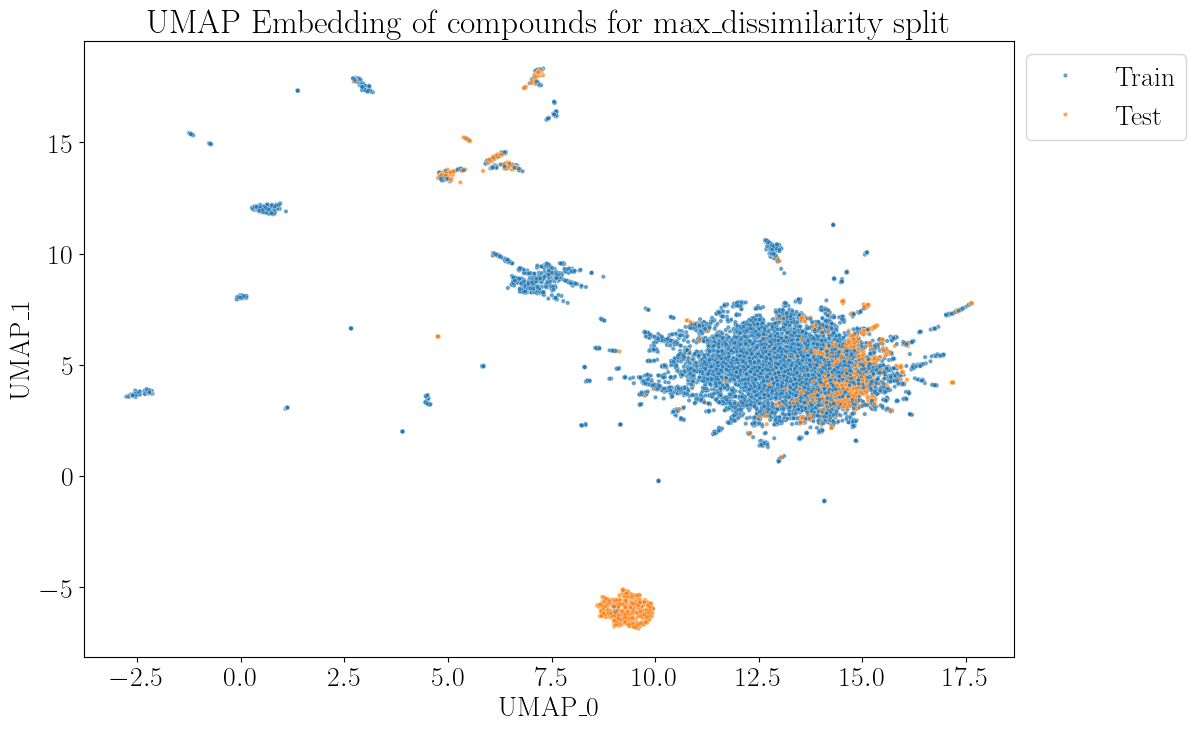

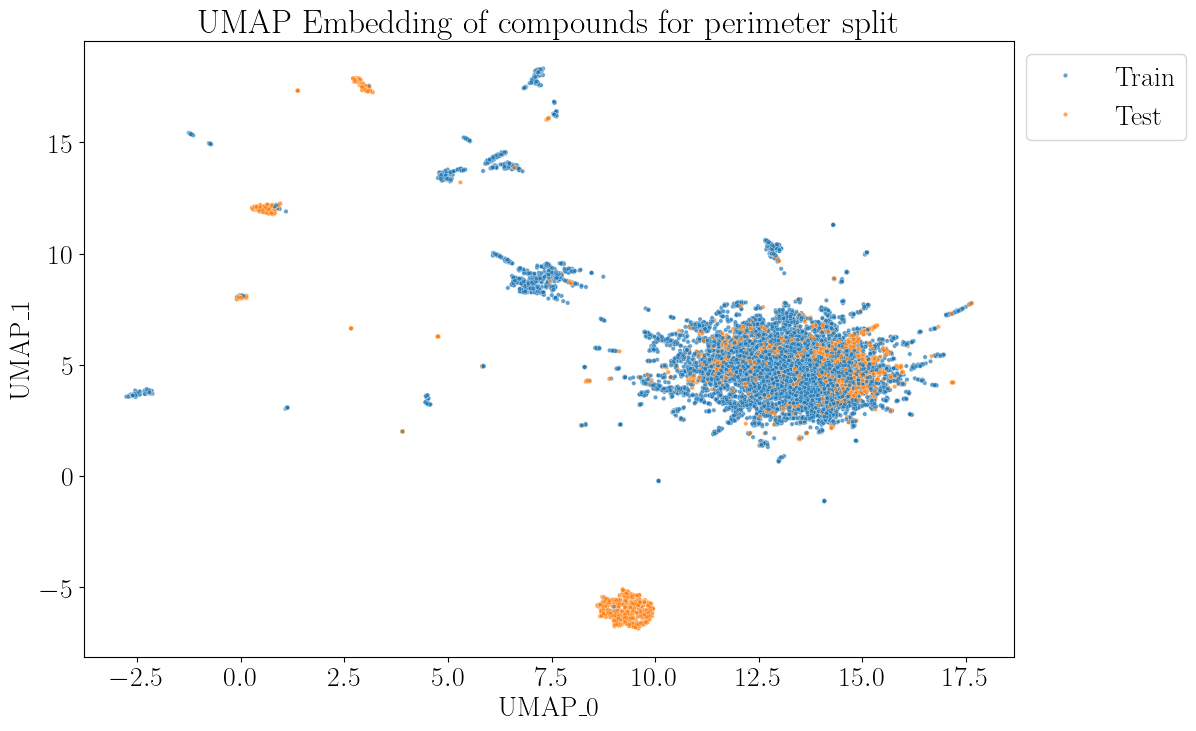

<Figure size 640x480 with 0 Axes>

In [17]:
import datamol as dm
import splito

In [18]:
DF_PATH = os.path.join(DATASET_PATH, "TDC", "CYP2C19", "CYP2C19_simplified.csv")
data = pd.read_csv(DF_PATH)
data.shape

(12665, 2)

In [19]:
# Define scaffold split
splitter = splito.ScaffoldSplit(smiles=data.smiles.tolist(), n_jobs=-1, test_size=0.1, random_state=111)

In [20]:
train_idx, test_idx = next(splitter.split(X=data["smiles"].values))
assert train_idx.shape[0] > test_idx.shape[0]

In [21]:
data.loc[train_idx, "ScaffoldSplit"] = "train"
data.loc[test_idx, "ScaffoldSplit"] = "test"
data["scaffold"] = splitter.scaffolds

In [22]:
data["ScaffoldSplit"].value_counts()

ScaffoldSplit
train    11414
test      1251
Name: count, dtype: int64

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

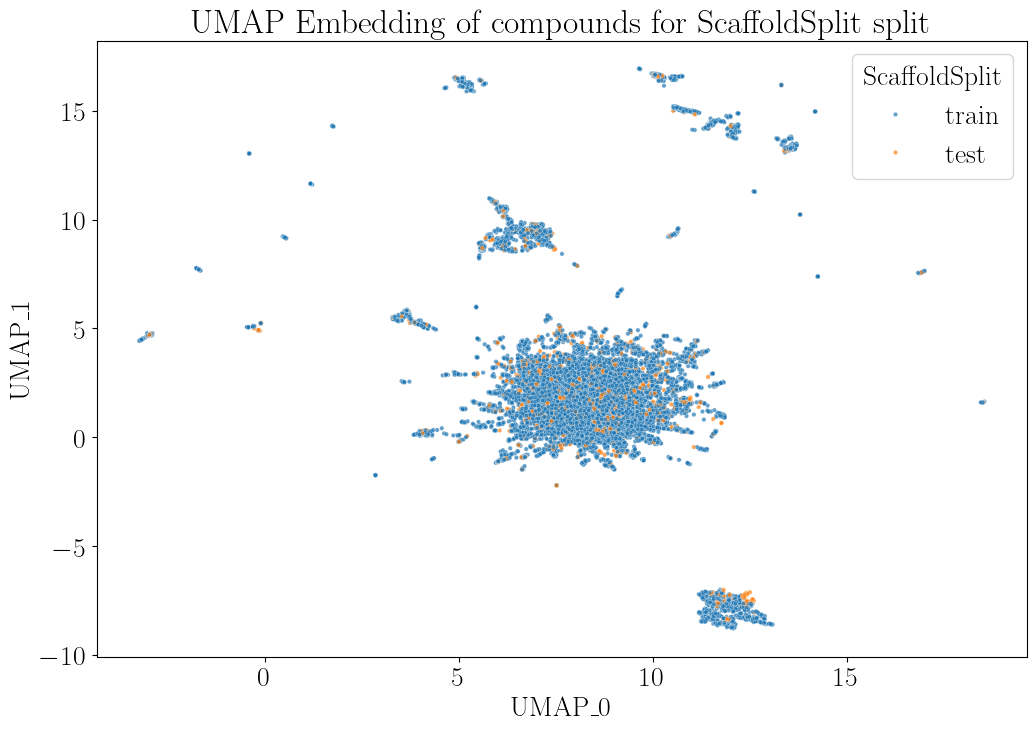

In [24]:
visualize_chemspace(data, split_names=["ScaffoldSplit"], size=10)

In [25]:
data

,smiles,label,ScaffoldSplit,scaffold,UMAP_0,UMAP_1
0,CCCC(=O)Nc1ccc(N2CCN(CC)CC2)c(Cl)c1.Cl,0,train,c1ccc(N2CCNCC2)cc1,9.557853,3.139632
1,CC(=O)N(c1ccc2oc(=O)sc2c1)S(=O)(=O)c1cccs1,1,train,O=c1oc2ccc(NS(=O)(=O)c3cccs3)cc2s1,7.717187,1.656112
2,Clc1ccccc1-c1nc(-c2ccccc2)n[nH]1,1,train,c1ccc(-c2n[nH]c(-c3ccccc3)n2)cc1,9.522059,0.786873
3,COc1ccccc1C(c1nnnn1C(C)(C)C)N1CCN(Cc2ccncc2)CC1,1,train,c1ccc(C(c2nnn[nH]2)N2CCN(Cc3ccncc3)CC2)cc1,9.813725,0.699903
4,COc1ccccc1CNC(=O)Cn1nnc(-c2ccncc2)n1,1,train,O=C(Cn1nnc(-c2ccncc2)n1)NCc1ccccc1,8.179121,3.715858
...,...,...,...,...,...,...
12660,CCN1C(=O)[C@@H]2[C@@H](CC[C@@H]3C(=O)C=C[C@@H]...,0,train,O=C1NC(=O)[C@@H]2CC[C@@H]3C(=O)C=CC[C@H]3[C@H]12,5.097229,16.109467
12661,O=C1[C@H]2CC=C3[C@@H]([C@H](O)[C@H]4O[C@@H]4C3...,0,train,O=C1[C@H]2[C@H](CC=C3[C@H]2C[C@H]2O[C@@H]2C32O...,6.363259,3.586334
12662,CCN1C(=O)[C@H]2CC=C3[C@@H]([C@H](O)[C@H]4O[C@@...,1,test,O=C1NC(=O)[C@H]2CC=C3[C@@H](C[C@H]4O[C@@H]4C34...,6.338778,3.489323
12663,C[C@H](c1ccccc1)N1C(=O)[C@@H]2[C@@H](CC[C@@H]3...,0,train,O=C1CCC[C@H]2[C@@H]3C(=O)N(Cc4ccccc4)C(=O)[C@@...,5.342569,16.228552


In [14]:
visualize_chemspace(data, split_names=["ScaffoldSplit"], mol_col="scaffold")

NameError: name 'data' is not defined

In [ ]:
# Define PerimeterSplit
splitter = splito.PerimeterSplit(n_jobs=-1, test_size=0.2, random_state=111)
train_idx, test_idx = next(splitter.split(X=data["smiles"].values))

assert train_idx.shape[0] > test_idx.shape[0]

data.loc[train_idx, splito.PerimeterSplit.__name__] = "train"
data.loc[test_idx, splito.PerimeterSplit.__name__] = "test"

In [ ]:
# Define PerimeterSplit
splitter = splito.MaxDissimilaritySplit(n_jobs=-1, test_size=0.2, random_state=111)
train_idx, test_idx = next(splitter.split(X=data.smiles.values))
assert train_idx.shape[0] > test_idx.shape[0]

data.loc[train_idx, "MaxDissimilaritySplit"] = "train"
data.loc[test_idx, "MaxDissimilaritySplit"] = "test"

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

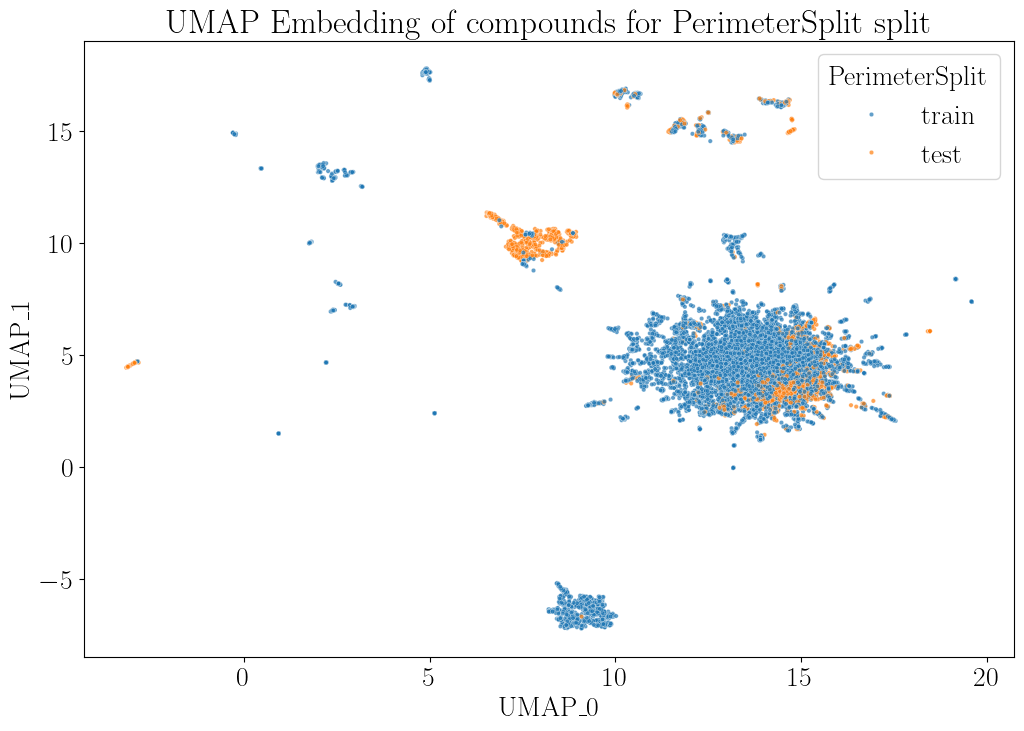

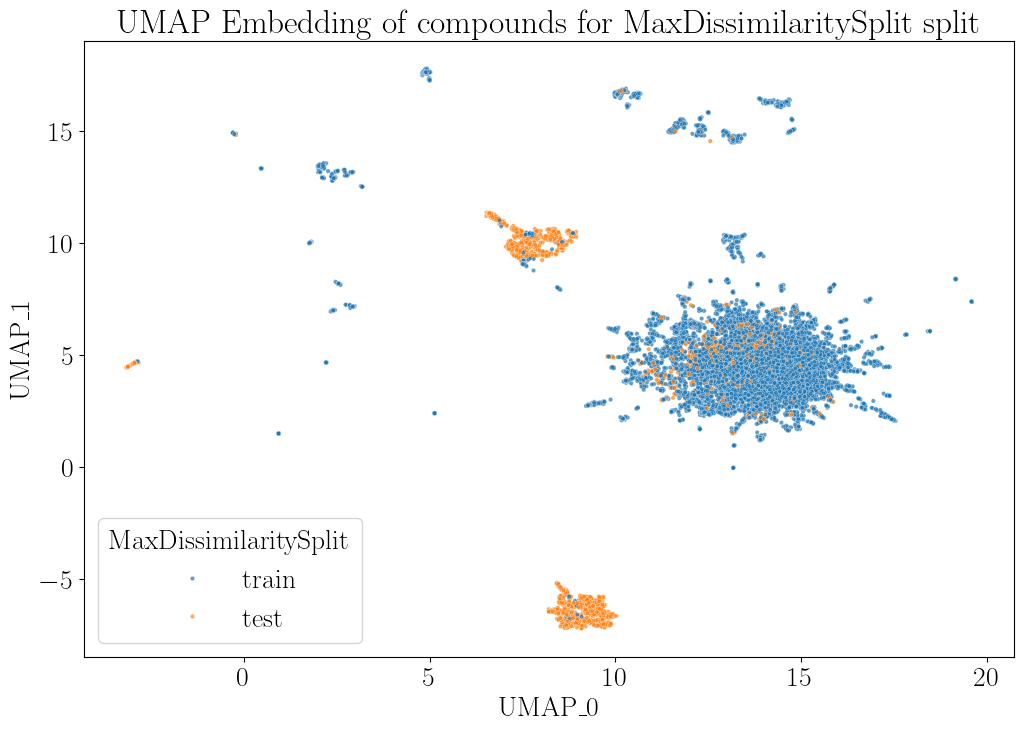

In [29]:
visualize_chemspace(data, split_names=["PerimeterSplit", "MaxDissimilaritySplit"])

##